# DeepRLBanana : Navigation Project

### Overview

This notebook contains the implementation for the Udacity's Deep Reinforcement Learning Navigation project. It uses the Unity ML Agents environment and runs a Deep Q-Learning model on the back-end to train the agent into collecting yellow bananas! 

Installation instructions as well as requirements have been specied in the README file of this project.

### 1. Import Libraries

In [1]:
from unityagents import UnityEnvironment
from collections import deque

import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# % matplotlib inline

# import the custom RL agent
from dqn_agent import Agent

### 2. Deep Q-Learning Proper

The dqn function is responsible for executing the core Deep Q Learning loop.


In [2]:
def dqn(n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    scores = []                                           # list containing scores from each episode
    scores_window = deque(maxlen=100)                     # last 100 scores
    eps = eps_start                                       # initialize epsilon
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]           # get states
        score = 0                                         # set initial score
        for t in range(max_t):
            action = agent.act(state, eps)                           # get action value
            env_info = env.step(action.astype(int))[brain_name]      
            next_state = env_info.vector_observations[0]             # get next state
            reward = env_info.rewards[0]                             # get reward
            done = env_info.local_done[0]                            # get value if done (boolean)
            agent.step(state, action, reward, next_state, done)      # moves agent one step
            state = next_state                                       # sets state to next state
            score += reward                                          # appends the reward to the total score
            if done:                                                 # check if done
                break                                                # breaks loop of episode
        scores_window.append(score)                       # save most recent score
        scores.append(score)                              # save most recent score
        eps = max(eps_end, eps_decay*eps)                 # decrease epsilon
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        
        if i_episode % 100 == 0:                          # tracks mean of consecutive 100 episodes
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
    print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
    torch.save(agent.qnetwork_local.state_dict(), 'model.pth')
    return scores

### 3. Create the Unity environment

Using the Banana.app environment, we construct the unity "brain" and the gather some basic meta data about the environment such as state and action spaces so that we can configure the DNN model initial and final layer sizes appropriately. 

In [3]:
env = UnityEnvironment("Banana_Windows_x86_64/Banana.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# number of actions
action_size = brain.vector_action_space_size

### 4. Train the agent

Kick off the training and store the score history for plotting

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

agent = Agent(state_size=state_size, action_size=action_size, seed=0)

print(agent.qnetwork_local)

scores = dqn()

QNetwork(
  (fc1): Linear(in_features=37, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=128, bias=True)
  (out): Linear(in_features=128, out_features=4, bias=True)
)
Episode 100	Average Score: 0.93
Episode 200	Average Score: 3.40
Episode 300	Average Score: 7.58
Episode 400	Average Score: 10.47
Episode 500	Average Score: 13.01
Episode 600	Average Score: 14.44
Episode 700	Average Score: 14.74
Episode 800	Average Score: 15.82
Episode 900	Average Score: 14.09
Episode 1000	Average Score: 15.11
Episode 1100	Average Score: 15.49
Episode 1200	Average Score: 16.20
Episode 1300	Average Score: 15.52
Episode 1400	Average Score: 14.74
Episode 1500	Average Score: 14.83
Episode 1600	Average Score: 14.70
Episode 1700	Average Score: 14.53
Episode 1800	Average Score: 14.58
Episode 1900	Average Score: 14.45
Episode 2000	Average Score: 14.76

Environment solved in 1900 episodes!	Average Score: 14.76


### 5. Plot the results

The raw scores chart shows the results of the individual espisodes. You will not it is very noisy. By applying a low pass filter, in this case a moving average, over the scores we can see clearly see the improvement in the agent over the episodes. 

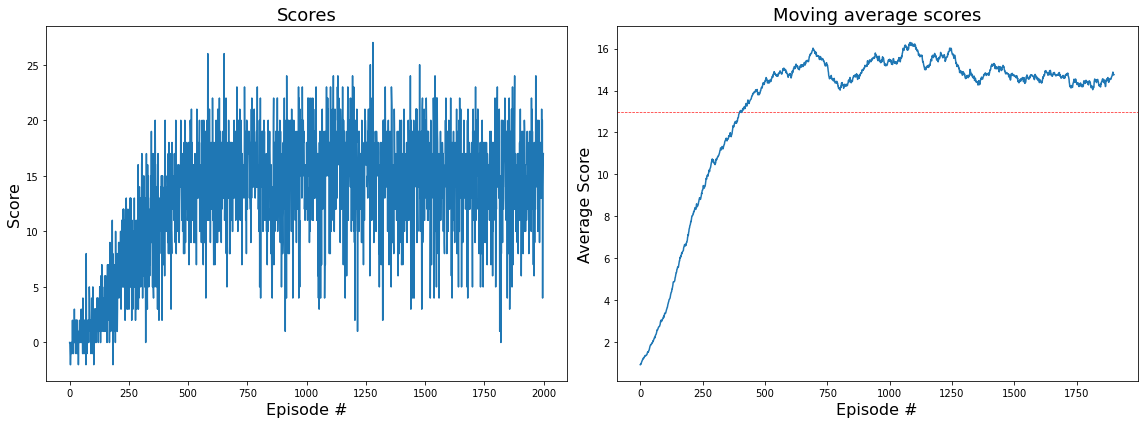

In [6]:
# helper function to generate moving average
def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

ls = 16
ts = 18

# plot the scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.plot(np.arange(len(scores)), scores)
ax1.set_ylabel('Score', fontsize=ls)
ax1.set_xlabel('Episode #', fontsize=ls)
ax1.set_title("Scores", fontsize=ts)

avg_score = moving_average(scores, 100)
ax2.axhline(y=13., xmin=0.0, xmax=1.0, color='r', linestyle='--', linewidth=0.7, alpha=0.9)
ax2.plot(np.arange(len(avg_score)), avg_score)
ax2.set_ylabel('Average Score', fontsize=ls)
ax2.set_xlabel('Episode #', fontsize=ls)
ax2.set_title("Moving average scores", fontsize=ts)

fig.savefig('dqn.jpg', format='jpg')
fig.tight_layout()

plt.show()

### 6. Play the trained agent

Now that we have trained the agent, we can then reset the environment into non-training. We then load the best weights from the run previously and let this trained agent play in the Banana environment.

In [8]:
# reset the environment to get the state space 
env_info = env.reset(train_mode=False)[brain_name]

# examine the state space 
state = env_info.vector_observations[0]
state_size = len(state)

# create the agent 
agent = Agent(state_size=state_size, action_size=action_size, seed=0)

#  run the agent ten times
for i in range(10):
    # load the weights from file
    agent.qnetwork_local.load_state_dict(torch.load('model.pth'))
    score = 0
    env_info = env.reset(train_mode=False)[brain_name]
    state = env_info.vector_observations[0]                        # get the current state
    for j in range(1000):
        action = agent.act(state)                                  # select an action
        env_info = env.step(action.astype(int))[brain_name]        # send the action to the environment
        next_state = env_info.vector_observations[0]
        reward = env_info.rewards[0]
        done = env_info.local_done[0]
        agent.step(state, action, reward, next_state, done)
        state = next_state
        score += reward
        if done:
            break 
    print('\rScore: {:.2f}'.format(score))

Score: 8.00
Score: 6.00
Score: 8.00
Score: 14.00
Score: 8.00
Score: 4.00
Score: 11.00
Score: 12.00
Score: 5.00
Score: 12.00


### 7. Close the environment

Once we are done, close the environment

In [ ]:
env.close()

### Conclusion and Recommendations

Solving the task only required a shallow architecture as a task as simple as this would not require more complicated algorithms. However, Dueling DQN or other enhancements are still worth exploring as I have noticed that increasing the episodes did not do much to the learning. 